Here we are trying to reconstuct the magnetic field using real data!!

In [1]:
import glob
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import gridspec
from b26_toolkit.src.data_analysis import nv_optical_response as nv
from PyLabControl.src.core import Script as script
%matplotlib inline

import scipy.optimize as opt

V_to_dist = 60 # convert galvo voltages to distances 1 V is about 60um

asdadadsad JG


In [2]:
# filename of esr data
filename_esr = glob.glob('Z:\\Lab\\Cantilever\\Measurements\\20171201_Sample_36_WithEnsemble\\171214-18_06_15_esr_many_pts_line_around_bead_1\\*.csv')[0]
# filename of select point script - contains the location of nvs
filename_points = 'Z:\\Lab\\Cantilever\\Measurements\\20171201_Sample_36_WithEnsemble\\171214-18_05_18_select_points'
#distance first point from center of bead in um
magnet_center = 2.4 * 0.2/11* V_to_dist
#diameter as estimated frm blob on fluorescence scan in um
magnet_diam = 1.0 * 0.2/11* V_to_dist
#diameter as from SEM (in um)
magnet_diam = 2.8

## testing how well the field amplitudes agree for the four families

In [3]:
nv_locations = script.load_data(filename_points)['nv_locations']
r = np.array([np.sqrt(np.sum((pt-nv_locations[0])**2)) for pt in nv_locations])*V_to_dist
# one esr is missing (remove one)
r = r[0:-1]+magnet_center
# take into account that we are at least a radius above the magnet
r = np.sqrt(r**2+magnet_diam/2)
dr = np.mean(np.diff(r))
esr_data = pd.DataFrame.from_csv(filename_esr)
B = []
for freq in np.array(esr_data):
    Bs = nv.calc_bfields_esr_ensemble_mag(freq)[1]
    Babs = np.sqrt(np.sum(Bs ** 2, axis=1)) # calculate the total field for all families
#     print('rel. error in field amplitude', np.std(Babs)/np.mean(Babs))
    B.append([np.mean(Babs), np.std(Babs)])
B = np.array(B).T

In [4]:
B_off = []
B_on = []
for freq in np.array(esr_data):
    Bs = nv.calc_bfields_esr_ensemble_mag(freq)[1]
#     print('rel. error in field amplitude', np.std(Babs)/np.mean(Babs))
    B_on.append(Bs[:,0])
    B_off.append(Bs[:,1])
B_on = np.array(B_on).T
B_off = np.array(B_off).T

In [5]:
line = ['-', '--']
colors = ['r', 'g', 'b']


def B_dipole(m, r):
    return m/(r)**3

def fit_err_fun(x, *argv):
    """
    error function for fitting to m/r^3
    """
    m = x

    r = argv[0]
    d = argv[1]
    f = B_dipole(m, r)
    
    err = np.std(d-f)
    return err

fit = opt.minimize(fit_err_fun, [0.6], args=(r, B[0]))
m = fit.x[0]
m

0.46598560789170734

In [6]:
'total field - B_r = {:0.2f}'.format(m)

'total field - B_r = 0.47'

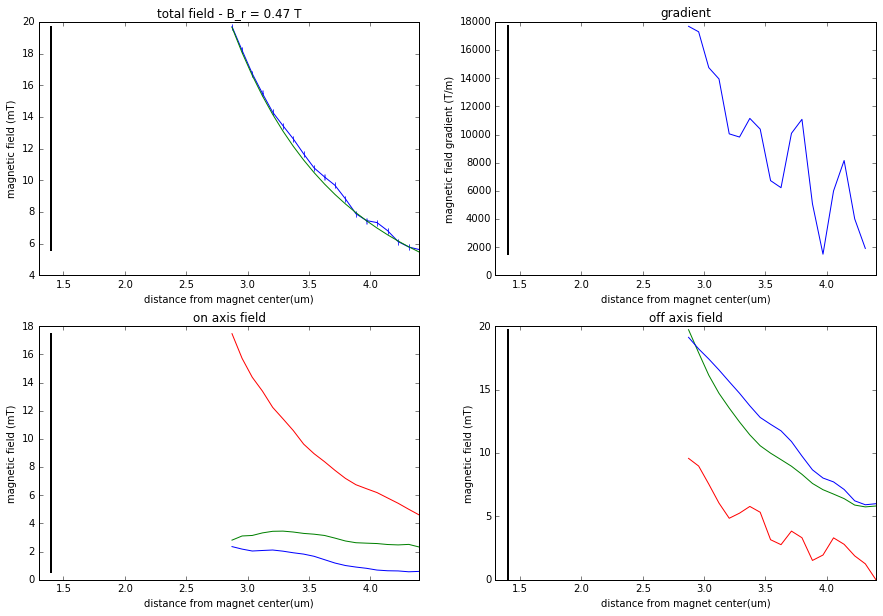

In [7]:
fig = plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.errorbar(r,1e3* B[0], xerr=B[1])
plt.plot(r,1e3* B_dipole(m, r))
plt.plot([magnet_diam/2, magnet_diam/2], [min(1e3* B[0]), max(1e3* B[0])], 'k-', lw = 2)
plt.xlim([magnet_diam/2-0.1, max(r)])
plt.title('total field - B_r = {:0.2f} T'.format(m))
plt.xlabel('distance from magnet center(um)')
plt.ylabel('magnetic field (mT)')

plt.subplot(2, 2, 2)
G = -np.diff(B[0])/dr*1e6
plt.plot(r[:-1],G)
plt.plot([magnet_diam/2, magnet_diam/2], [min(G), max(G)], 'k-', lw = 2)
plt.xlim([magnet_diam/2-0.1, max(r)])
plt.title('gradient')
plt.xlabel('distance from magnet center(um)')
plt.ylabel('magnetic field gradient (T/m)')

plt.subplot(2, 2, 3)
for i, b in enumerate(B_on):
    plt.plot(r,1e3* b, colors[i])
plt.plot([magnet_diam/2, magnet_diam/2], [np.min(B_on)*1e3, np.max(B_on)*1e3], 'k-', lw = 2)
plt.xlim([magnet_diam/2-0.1, max(r)])
plt.title('on axis field')
plt.xlabel('distance from magnet center(um)')
plt.ylabel('magnetic field (mT)')

plt.subplot(2, 2, 4)
for i, b in enumerate(B_off):
    plt.plot(r,1e3* b, colors[i])
plt.plot([magnet_diam/2, magnet_diam/2], [np.min(B_off)*1e3, np.max(B_off)*1e3], 'k-', lw = 2)
plt.xlim([magnet_diam/2-0.1, max(r)])
plt.title('off axis field')
plt.xlabel('distance from magnet center(um)')
plt.ylabel('magnetic field (mT)')

fig.savefig('fields.png')

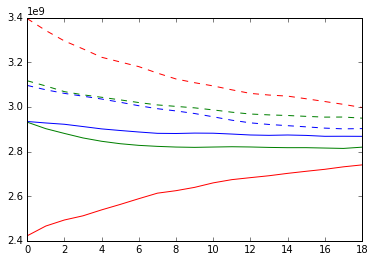

In [9]:
# look at frequencies
for i, x in enumerate(np.array([np.reshape(f, (len(f)/2, 2)) for f in np.array(esr_data)]).T):
    for j, y in enumerate(x):
        plt.plot(y, line[i]+colors[j])